In [23]:
from google.colab import files
uploaded = files.upload()

Saving children_books.csv to children_books (1).csv


In [24]:
# Step 1: Setup & Load
# !pip install -q pandas numpy scikit-learn sentence-transformers tqdm

import os, pandas as pd, numpy as np

DATA_PATH = "children_books.csv"  # change if needed

# Robust CSV read
try:
    df = pd.read_csv(DATA_PATH)
except Exception:
    df = pd.read_csv(DATA_PATH, engine="python", sep=None)

print(f"Loaded: {df.shape[0]:,} rows × {df.shape[1]} cols\n")
print("Columns:", list(df.columns), "\n")
print(df.head(3))

# Heuristic: pick the main text column by avg length among object cols
obj_cols = [c for c in df.columns if df[c].dtype == "object"]
avg_len = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
TEXT_COL = max(avg_len, key=avg_len.get)
print("\nGuessed TEXT_COL:", TEXT_COL, " | avg length ≈", round(avg_len[TEXT_COL], 2))

# Quick quality checks
print("Nulls in text:", df[TEXT_COL].isna().sum())
print("Duplicate descriptions:", df.duplicated(subset=[TEXT_COL]).sum())

# Optional: peek at short snippets
print("\nSample snippets:")
print(df[TEXT_COL].astype(str).str.slice(0, 160).head(5).to_string(index=False))


Loaded: 3,269 rows × 5 cols

Columns: ['Title', 'Author', 'Desc', 'Inerest_age', 'Reading_age'] 

                         Title                Author  \
0  The Girl Who Drank the Moon        Kelly Barnhill   
1              Time Between Us  Tamara Ireland Stone   
2            Girl Out of Water         Nat Luurtsema   

                                                Desc Inerest_age  \
0  Every year, the evil Protectorate offers a bab...      10-14    
1  Sixteen-year-old Anna is struggling to underst...        13+    
2  Lou Brown's swimming ambitions sank without tr...      13-18    

                            Reading_age  
0  10-14                                 
1    12+                                 
2    10+                                 

Guessed TEXT_COL: Desc  | avg length ≈ 966.98
Nulls in text: 0
Duplicate descriptions: 3228

Sample snippets:
Every year, the evil Protectorate offers a baby...
Sixteen-year-old Anna is struggling to understa...
Lou Brown's swimming am

In [25]:
# Step 2: Clean + tokenize + bigrams
import re
from collections import Counter

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)   # remove URLs
    s = re.sub(r"[^a-z0-9\s']+", " ", s)           # keep letters/digits/apostrophes
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize(s: str):
    return [t for t in clean_text(s).split() if t]

def to_bigrams(tokens):
    return [f"{tokens[i]}_{tokens[i+1]}" for i in range(len(tokens)-1)]

# main columns
df["tokens"]  = df[TEXT_COL].apply(tokenize)
df["bigrams"] = df["tokens"].apply(to_bigrams)
df["uni_bi"]  = df.apply(lambda r: r["tokens"] + r["bigrams"], axis=1)

# quick peek
df[[TEXT_COL, "tokens", "bigrams", "uni_bi"]].head(5)


,Desc,tokens,bigrams,uni_bi
0,"Every year, the evil Protectorate offers a bab...","[every, year, the, evil, protectorate, offers,...","[every_year, year_the, the_evil, evil_protecto...","[every, year, the, evil, protectorate, offers,..."
1,Sixteen-year-old Anna is struggling to underst...,"[sixteen, year, old, anna, is, struggling, to,...","[sixteen_year, year_old, old_anna, anna_is, is...","[sixteen, year, old, anna, is, struggling, to,..."
2,Lou Brown's swimming ambitions sank without tr...,"[lou, brown's, swimming, ambitions, sank, with...","[lou_brown's, brown's_swimming, swimming_ambit...","[lou, brown's, swimming, ambitions, sank, with..."
3,Robyn is scared. Ever since the attempted assa...,"[robyn, is, scared, ever, since, the, attempte...","[robyn_is, is_scared, scared_ever, ever_since,...","[robyn, is, scared, ever, since, the, attempte..."
4,Welcome to the School of Music. In charge is M...,"[welcome, to, the, school, of, music, in, char...","[welcome_to, to_the, the_school, school_of, of...","[welcome, to, the, school, of, music, in, char..."


In [26]:
# ---- Step 3: Vocabulary + DTM (BoW counts) ----
import numpy as np
import pandas as pd
from collections import Counter

vocab = sorted(set(tok for doc in df["uni_bi"] for tok in doc))
tok2idx = {t: i for i, t in enumerate(vocab)}
print("Vocab size:", len(vocab))

X = np.zeros((len(df), len(vocab)), dtype=np.int32)
for i, doc in enumerate(df["uni_bi"]):
    cnt = Counter(doc)
    for t, c in cnt.items():
        j = tok2idx.get(t)
        if j is not None:
            X[i, j] = c

bow_df = pd.DataFrame(X, columns=vocab, index=df.index)
print("BoW shape (docs, terms):", bow_df.shape)

# small visible slice
bow_df.iloc[:3, :60]


Vocab size: 7829
BoW shape (docs, terms): (3269, 7829)


,','_'where,'_jane,'accidentally','accidentally'_and,'america's,'america's_fattest,'butter','butter'_as,'face,...,18th_century,1930s,1930s_her,1949,1949_this,1970s,1970s_which,1985,1985_to,1995
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,count
the,28397
and,21032
a,16107
of,16055
to,14988
is,11987
in,8628
her,7519
with,6554
his,5016


,Desc,tokens,bigrams
0,"Every year, the evil Protectorate offers a bab...","[every, year, the, evil, protectorate, offers,...","[every_year, year_the, the_evil, evil_protecto..."


,count
the,13
and,12
to,8
a,5
of,5
xan,4
witch,3
is,3
it,3
s,3


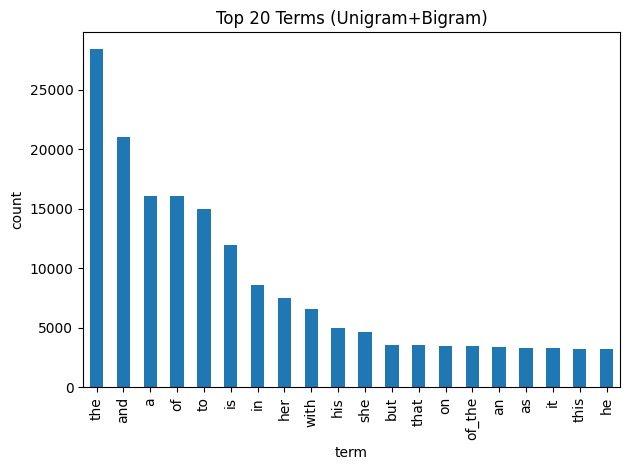

In [27]:
# Step 4: Top terms + QC
total_counts = bow_df.sum(axis=0).sort_values(ascending=False)
display(total_counts.head(25).to_frame("count"))

# check one row against original text
row = 0
display(df.iloc[[row]][[TEXT_COL, "tokens", "bigrams"]])
display(bow_df.iloc[row].sort_values(ascending=False).head(20).to_frame("count"))

# (optional) simple matplotlib bar chart of top 20
import matplotlib.pyplot as plt
top20 = total_counts.head(20)
plt.figure()
top20.plot(kind="bar")
plt.title("Top 20 Terms (Unigram+Bigram)")
plt.xlabel("term"); plt.ylabel("count")
plt.tight_layout(); plt.show()


In [28]:
# Step 5: Save artifacts
bow_df.to_csv("bow_children_books.csv", index=False)
df[[TEXT_COL, "tokens", "bigrams", "uni_bi"]].to_csv("children_books_clean.csv", index=False)
with open("vocab_children_books.txt", "w", encoding="utf-8") as f:
    for t in bow_df.columns:
        f.write(t + "\n")

print("Saved -> bow_children_books.csv, children_books_clean.csv, vocab_children_books.txt")


Saved -> bow_children_books.csv, children_books_clean.csv, vocab_children_books.txt


In [29]:
# Children Stories — Embeddings + Average + Cosine Compare
# If you're in Colab, uncomment:
!pip install -q sentence-transformers tqdm pandas numpy

import os, math, json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# Config
DATA_PATH  = "children_books.csv"
TEXT_COL   = "Desc"                                 # main text column
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

EMB_FILE   = "children_books_embeddings.npy"        # per-doc embeddings (N, D)
AVG_FILE   = "children_books_avg_embedding.npy"     # single vector (D,)
IDX_FILE   = "children_books_index.json"            # metadata for nice printing

# 1) Load dataset
assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

# Safety: if TEXT_COL missing, auto-pick the longest object column
if TEXT_COL not in df.columns:
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    avg_len = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
    TEXT_COL = max(avg_len, key=avg_len.get)
    print(f"[auto] Using TEXT_COL = {TEXT_COL}")

# Build the text we’ll embed (you can append Title if you want more context)
def safe(x): return "" if pd.isna(x) else str(x)
df["text"] = df[TEXT_COL].map(safe)

# Optional dedupe so average isn’t biased by duplicate blurbs
before = len(df)
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
print(f"Loaded {before:,} rows → {len(df):,} unique texts. Column used: {TEXT_COL}")

texts = df["text"].astype(str).tolist()

# 2) Build or load embeddings
def _batch(lst, n=256):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def build_or_load_embeddings(texts, model_name, save_path) -> np.ndarray:
    if os.path.exists(save_path):
        embs = np.load(save_path)
        print(f"Loaded cached embeddings: {save_path} -> {embs.shape}")
        return embs
    print(f"Computing embeddings with {model_name} ...")
    model = SentenceTransformer(model_name)
    out = []
    for chunk in tqdm(_batch(texts, 256), total=math.ceil(len(texts)/256)):
        vecs = model.encode(
            chunk,
            convert_to_numpy=True,
            normalize_embeddings=True  # L2-normalized → cosine = dot
        )
        out.append(vecs)
    embs = np.vstack(out)
    np.save(save_path, embs)
    print(f"Saved per-doc embeddings → {save_path}")
    return embs

embs = build_or_load_embeddings(texts, MODEL_NAME, EMB_FILE)   # shape (N, D)
print("Per-doc embeddings shape:", embs.shape)

# 3) Average embedding for ALL stories
avg_vec = embs.mean(axis=0)                            # (D,)
avg_vec = avg_vec / (np.linalg.norm(avg_vec) + 1e-12)  # normalize for cosine
np.save(AVG_FILE, avg_vec)
print("Saved average embedding →", AVG_FILE)
print("Average embedding shape:", avg_vec.shape, "| first 8 dims:", avg_vec[:8])

# Save minimal index for nicer printing later
meta = {
    "rows": len(df),
    "title": df["Title"].tolist() if "Title" in df.columns else [""]*len(df),
    "text_preview": [t[:180] for t in texts],
}
with open(IDX_FILE, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False)
print("Saved index →", IDX_FILE)

# 4) Similarity helpers
# (A) Compare any text to the single average vector
_model_cache = None
def _get_model():
    global _model_cache
    if _model_cache is None:
        _model_cache = SentenceTransformer(MODEL_NAME)
    return _model_cache

def similarity_to_corpus_average(text: str) -> float:
    """Cosine similarity between text and the CORPUS AVERAGE."""
    model = _get_model()
    q = model.encode([text], convert_to_numpy=True, normalize_embeddings=True)  # (1, D)
    return float(np.dot(q, avg_vec))  # cosine because vectors are normalized

# (B) Top-k nearest individual stories
def topk_similar(text: str, k: int = 5):
    """Return top-k (index, score) against individual docs."""
    model = _get_model()
    q = model.encode([text], convert_to_numpy=True, normalize_embeddings=True)  # (1, D)
    sims = embs @ q.T  # (N, 1) dot with normalized → cosine
    sims = sims.ravel()
    k = min(k, len(sims))
    idx = np.argpartition(-sims, range(k))[:k]
    idx = idx[np.argsort(-sims[idx])]
    return [(int(i), float(sims[i])) for i in idx]

def print_topk(text: str, k: int = 5):
    hits = topk_similar(text, k=k)
    for r, (i, s) in enumerate(hits, 1):
        title = df.iloc[i]["Title"] if "Title" in df.columns else ""
        snippet = df.iloc[i]["text"][:180].replace("\n", " ")
        print(f"{r:>2}. score={s:.4f} | {title}\n    {snippet}\n")

# 5) Example usage

example_gpt = "A warm bedtime story where a shy child and a friendly dragon learn courage and kindness together."
print("\nSimilarity to CORPUS AVERAGE:", round(similarity_to_corpus_average(example_gpt), 4))
print("\nTop-5 nearest individual stories:")
print_topk(example_gpt, k=5)


Loaded 3,269 rows → 41 unique texts. Column used: Desc
Loaded cached embeddings: children_books_embeddings.npy -> (41, 384)
Per-doc embeddings shape: (41, 384)
Saved average embedding → children_books_avg_embedding.npy
Average embedding shape: (384,) | first 8 dims: [-0.04029403 -0.00402843  0.02580307  0.01727206  0.00578296  0.03106725
  0.06628994 -0.0074236 ]
Saved index → children_books_index.json

Similarity to CORPUS AVERAGE: 0.4572

Top-5 nearest individual stories:
 1. score=0.4113 | Kite Spirit
    When her best friend Dawn commits suicide, Kite's world falls apart. Struggling to deal with her hearbreaking grief, she leaves London with her father to spend the summer in the La

 2. score=0.3806 | Paper Avalanche
    Fourteen-year-old Ro Snow’s got a secret: her house is filled to the doors with her mother’s hoarded rubbish: it’s so bad that there’s even rubbish in the bath, meaning the only wa

 3. score=0.3654 | A Flash of Blue
    Since Amber's eighteen year old brother Liam

/tmp/ipython-input-1210348507.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.dot(q, avg_vec))  # cosine because vectors are normalized
